In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [10]:
df = pd.read_csv("online_retail_II.csv")

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
df.describe()

,Quantity,Price,Customer ID
count,188661.000000,188661.000000,144713.000000
mean,11.016681,4.767892,15326.666215
std,123.257106,147.171508,1673.412464
min,-9200.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13971.000000
50%,3.000000,2.100000,15240.000000
75%,10.000000,4.250000,16788.000000
max,19152.000000,10953.500000,18287.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188661 entries, 0 to 188660
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      188661 non-null  object 
 1   StockCode    188661 non-null  object 
 2   Description  187303 non-null  object 
 3   Quantity     188661 non-null  int64  
 4   InvoiceDate  188661 non-null  object 
 5   Price        188661 non-null  float64
 6   Customer ID  144713 non-null  float64
 7   Country      188661 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 11.5+ MB


In [14]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,1358
Quantity,0
InvoiceDate,0
Price,0
Customer ID,43948
Country,0


In [15]:
df = df.dropna(subset=["Customer ID"])

In [16]:
df = df.dropna(subset=["Description"])

In [17]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


In [18]:
df.duplicated().sum()

np.int64(2106)

In [19]:
df.drop_duplicates(inplace=True)

In [20]:
df['InvoiceDate'] = pd.to_datetime(df["InvoiceDate"])

In [21]:
# Add TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

In [22]:
# Summary
print("Total Customers:", df['Customer ID'].nunique())
print("Top 5 countries:", df['Country'].value_counts().head())

Total Customers: 2581
Top 5 countries: Country
United Kingdom    129942
EIRE                3128
Germany             3012
France              1916
Netherlands          895
Name: count, dtype: int64


In [23]:
import pandas as pd
import datetime as dt

In [24]:
# Reference date = last date in dataset + 1 day
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [25]:
# RFM table
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).reset_index()

In [26]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [27]:
# Check RFM stats
print(rfm.describe())

         CustomerID      Recency    Frequency       Monetary
count   2581.000000  2581.000000  2581.000000    2581.000000
mean   15322.181713    54.572646     3.263076    1160.783026
std     1684.908965    46.313089     5.202950    4857.050032
min    12346.000000     1.000000     1.000000  -10953.500000
25%    13854.000000    15.000000     1.000000     220.410000
50%    15302.000000    43.000000     2.000000     447.050000
75%    16777.000000    84.000000     4.000000     974.770000
max    18287.000000   158.000000    92.000000  139649.600000


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [30]:
# Elbow method to find optimal clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

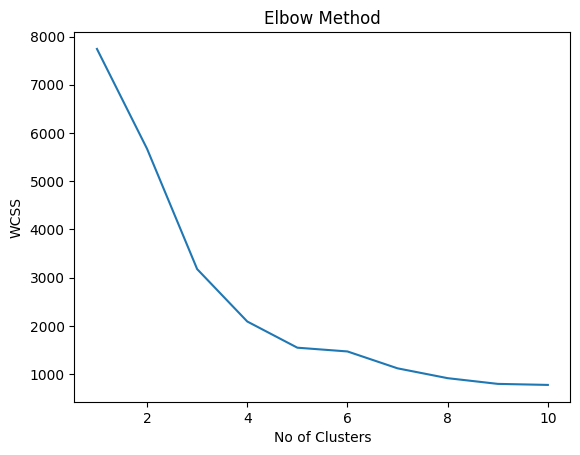

In [31]:
# Plot
plt.plot(range(1, 11), wcss)
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

In [32]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

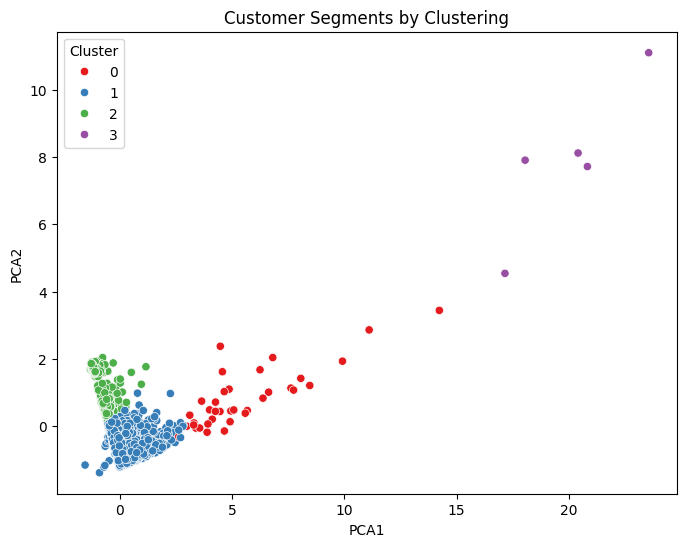

In [34]:
# Optional: use PCA for 2D plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = components[:, 0]
rfm['PCA2'] = components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='Set1')
plt.title("Customer Segments by Clustering")
plt.show()

In [35]:
# Reference date (last 30 days)
cutoff_date = df['InvoiceDate'].max() - pd.Timedelta(days=30)

In [36]:
# Customers who purchased in last 30 days
active_customers = df[df['InvoiceDate'] > cutoff_date]['Customer ID'].unique()

In [37]:
# Add target column
rfm['WillPurchaseNext30Days'] = rfm['CustomerID'].apply(lambda x: 1 if x in active_customers else 0)

In [38]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['WillPurchaseNext30Days']

In [39]:
# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [42]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [44]:
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       214

    accuracy                           1.00       517
   macro avg       1.00      1.00      1.00       517
weighted avg       1.00      1.00      1.00       517

ROC AUC Score: 1.0


In [45]:
import joblib

In [56]:
# Save model
joblib.dump(model, 'model/purchase_predictor.pkl')
joblib.dump(scaler, 'model/scaler.pkl')

['model/scaler.pkl']